In [ ]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.types import Integer, Text, String, DateTime, Float
import psycopg2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopy
from geopy.geocoders import Nominatim
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
# # link to postgresql on my local machine
# # https://naysan.ca/2020/05/31/postgresql-to-pandas/
# param_dic = {
#     "host"      : "localhost",  
#     "database"  : "Meteorites",
#     "user"      : "postgres",
#     "password"  : "postgres"
# }
# def connect(params_dic):
#     """ Connect to the PostgreSQL database server """
#     conn = None
#     try:
#         # connect to the PostgreSQL server
#         print('Connecting to the PostgreSQL database...')
#         conn = psycopg2.connect(**params_dic)
#     except (Exception, psycopg2.DatabaseError) as error:
#         print(error)
#         sys.exit(1) 
#     print("Connection successful")
#     return conn

In [ ]:
# link to aws
# https://naysan.ca/2020/05/31/postgresql-to-pandas/
param_dic = {
    "host"      : "meteorite-ml-db.cl3jquwwq7kn.us-east-1.rds.amazonaws.com",  
    "database"  : "meteorite_ml_db",
    "user"      : "postgres",
    "password"  : "project4team5"
}
def connect(params_dic):
    """ Connect to the PostgreSQL/AWS database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL/AWS database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

In [4]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [5]:
landcover_cols=["id","state_abbrev","variable","value"]
state_cols=["state_abbrev","state","FIPS","area_sqkm","country"]
meteorite_type_cols=["recclass","meteorite_class_subclass","meteorite_class","meteorite_type"]
meteorite_main_cols=["id","name","recclass","mass_grams","fall","year","reclat","reclong","geolocation","geometry","elevation","country","state_abbrev"]



In [6]:
conn = connect(param_dic)


Connecting to the PostgreSQL database...
Connection successful


In [7]:
state_df = postgresql_to_dataframe(conn,"select * from state",state_cols)
state_df.head()

,state_abbrev,state,FIPS,area_sqkm,country
0,AL,Alabama,1,135767,United States
1,AK,Alaska,2,1723337,United States
2,AZ,Arizona,4,295234,United States
3,AR,Arkansas,5,137732,United States
4,CA,California,6,423967,United States


In [8]:
landcover_df = postgresql_to_dataframe(conn,"select * from landcover",landcover_cols)
landcover_df.head()

,id,state_abbrev,variable,value
0,1,AL,FOREST,64.872148
1,2,AL,GRSL,19.904490
2,3,AL,WETL,0.176988
3,4,AL,SHRUBL,1.222573
4,5,AL,SPARSE_VEGETATION,0.034765


In [9]:
# remove ID column and set state abbreviation to index
landcover_df.drop(['id'], axis=1, inplace=True)
landcover_df.set_index('state_abbrev', inplace=True)
landcover_df

,variable,value
state_abbrev,,
AL,FOREST,64.872148
AL,GRSL,19.904490
AL,WETL,0.176988
AL,SHRUBL,1.222573
AL,SPARSE_VEGETATION,0.034765
...,...,...
VA,SPARSE_VEGETATION,0.025975
VA,CROPL,10.927344
VA,URBAN,2.967337


In [16]:
# flatten out landcover data
# pivot table to create columns for each variable
landcovery = (landcover_df.pivot_table(index = landcover_df.index, columns='variable',values = 'value', aggfunc=lambda x: x, fill_value=0)
       .rename_axis(None, axis='columns')
      
)
landcovery.reset_index(inplace=True)
print(len(landcovery))
landcovery.head(2)

51


,state_abbrev,BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
0,AK,10.875705,0.045602,34.319849,10.628187,20.993753,15.991683,0.014371,5.340909,1.789941
1,AL,0.189766,10.177265,64.872148,19.904490,1.222573,0.034765,1.659720,1.762286,0.176988


In [11]:
meteorite_type_df = postgresql_to_dataframe(conn,"select * from meteorite_type",meteorite_type_cols)
meteorite_type_df.head()

,recclass,meteorite_class_subclass,meteorite_class,meteorite_type
0,H5,Chrondrite - ordinary,Chrondrite,Chrondrite
1,L6,Chrondrite - ordinary,Chrondrite,Chrondrite
2,L5,Chrondrite - ordinary,Chrondrite,Chrondrite
3,"Iron, ungrouped",Iron - other,Iron,Iron
4,"Iron, IVA",Iron - magmatic,Iron,Iron


In [12]:
meteorite_main_df = postgresql_to_dataframe(conn,"select * from meteorite_main",meteorite_main_cols)
meteorite_main_df.head()

,id,name,recclass,mass_grams,fall,year,reclat,reclong,geolocation,geometry,elevation,country,state_abbrev
0,2276,Allegan,H5,32000.0,Fell,1899,42.53333,-85.88333,"(42.53333, -85.88333)",POINT (-85.88333 42.53333),225.0,United States,MI
1,5401,Coleman,L6,469.0,Fell,1994,43.76111,-84.50778,"(43.76111, -84.50778)",POINT (-84.50778 43.76111),218.0,United States,MI
2,22766,Rose City,H5,10600.0,Fell,1921,44.51667,-83.95000,"(44.51667, -83.95)",POINT (-83.95 44.51667),387.0,United States,MI
3,24337,Worden,L5,1551.0,Fell,1997,42.38467,-83.61150,"(42.38467, -83.6115)",POINT (-83.6115 42.38467),279.0,United States,MI
4,10955,Grand Rapids,"Iron, ungrouped",51700.0,Found,1883,42.96667,-85.76667,"(42.96667, -85.76667)",POINT (-85.76667 42.96667),225.0,United States,MI


In [18]:
ml_interim5_cols =  ['mass_grams', 'fall', 'year', 'reclat', 'reclong', 'elevation','state_abbrev', 'FIPS', 'area_sqkm', 'meteorite_class']

In [19]:
# pull in all data except for landcover using sql
ml_interim5_df = postgresql_to_dataframe(conn,"select mm.mass_grams, mm.fall, mm.year, mm.reclat, mm.reclong, mm.elevation, s.state_abbrev, s.FIPS, s.area_sqkm, mt.meteorite_class from meteorite_main mm, meteorite_type mt, state s where mm.state_abbrev = s.state_abbrev and mm.recclass = mt.recclass;",ml_interim5_cols) 
ml_interim5_df.head()

,mass_grams,fall,year,reclat,reclong,elevation,state_abbrev,FIPS,area_sqkm,meteorite_class
0,32000.0,Fell,1899,42.53333,-85.88333,225.0,MI,26,250487,Chrondrite
1,469.0,Fell,1994,43.76111,-84.50778,218.0,MI,26,250487,Chrondrite
2,10600.0,Fell,1921,44.51667,-83.95000,387.0,MI,26,250487,Chrondrite
3,1551.0,Fell,1997,42.38467,-83.61150,279.0,MI,26,250487,Chrondrite
4,51700.0,Found,1883,42.96667,-85.76667,225.0,MI,26,250487,Iron


In [22]:
ml_interim4_df = pd.merge(ml_interim5_df,landcovery, on = 'state_abbrev')
ml_interim4_df.drop(['state_abbrev'], axis = 1, inplace=True)
print(len(ml_interim4_df))
ml_interim4_df.head(2)

1648


,mass_grams,fall,year,reclat,reclong,elevation,FIPS,area_sqkm,meteorite_class,BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
0,32000.0,Fell,1899,42.53333,-85.88333,225.0,26,250487,Chrondrite,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346
1,469.0,Fell,1994,43.76111,-84.50778,218.0,26,250487,Chrondrite,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346


In [23]:
# replace fall with Fell=0, Fall=1
print(ml_interim4_df['fall'].unique())
ml_interim4_df.replace(['Fell',"Found"],[0,1],inplace = True)
print(len(ml_interim4_df))
ml_interim4_df.head(2)

['Fell' 'Found']
1648


,mass_grams,fall,year,reclat,reclong,elevation,FIPS,area_sqkm,meteorite_class,BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
0,32000.0,0,1899,42.53333,-85.88333,225.0,26,250487,Chrondrite,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346
1,469.0,0,1994,43.76111,-84.50778,218.0,26,250487,Chrondrite,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346


In [27]:
# create meteorite_class dummy columns
dummies = pd.get_dummies(ml_interim4_df['meteorite_class'])
ml_unscaled = pd.concat([ml_interim4_df,dummies], axis='columns')
ml_unscaled.drop(['meteorite_class'],axis='columns', inplace = True)
print(len(ml_unscaled))
ml_unscaled.head(2)

1648


,mass_grams,fall,year,reclat,reclong,elevation,FIPS,area_sqkm,BARE,CROPL,...,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL,Achrondrite,Chrondrite,Iron,Mesosiderite,Pallasite
0,32000.0,0,1899,42.53333,-85.88333,225.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
1,469.0,0,1994,43.76111,-84.50778,218.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0


In [28]:
# write US meteorite data into csv file
ml_unscaled.to_csv('Resources/machine_learning/meteorite_ml_unscaled.csv')

In [29]:
# check csv
ml_unscaled_check = pd.read_csv('Resources/machine_learning/meteorite_ml_unscaled.csv')
print(len(ml_unscaled_check))
ml_unscaled_check.head(2)

1648


,Unnamed: 0,mass_grams,fall,year,reclat,reclong,elevation,FIPS,area_sqkm,BARE,...,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL,Achrondrite,Chrondrite,Iron,Mesosiderite,Pallasite
0,0,32000.0,0,1899,42.53333,-85.88333,225.0,26,250487,0.241572,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
1,1,469.0,0,1994,43.76111,-84.50778,218.0,26,250487,0.241572,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0


In [30]:
collist = ml_unscaled.columns.to_list()

In [31]:
# try to force all cols to numeric  from Mod19-Day03-Act-05
for col in ml_unscaled.columns:
    if ml_unscaled[col].dtype == 'object':
        ml_unscaled[col] = pd.to_numeric(ml_unscaled[col], errors='coerce')

In [32]:
# set x and y
X = ml_unscaled.drop('fall', axis=1)
y = ml_unscaled['fall']
print(len(X))
print(type(X))
print(X)


1648
<class 'pandas.core.frame.DataFrame'>
      mass_grams  year    reclat    reclong  elevation  FIPS  area_sqkm  \
0        32000.0  1899  42.53333  -85.88333      225.0    26     250487   
1          469.0  1994  43.76111  -84.50778      218.0    26     250487   
2        10600.0  1921  44.51667  -83.95000      387.0    26     250487   
3         1551.0  1997  42.38467  -83.61150      279.0    26     250487   
4        51700.0  1883  42.96667  -85.76667      225.0    26     250487   
...          ...   ...       ...        ...        ...   ...        ...   
1643    111000.0  1926  42.33333 -113.70000     1914.0    16     216443   
1644      2150.0  1940  43.80000 -117.00000      670.0    16     216443   
1645        41.0  2004  44.93389 -116.43167     1556.0    16     216443   
1646     26600.0  1982  43.72444 -116.91167      716.0    16     216443   
1647       353.0  1963  42.31667  -72.63333       51.0    25      27336   

          BARE      CROPL     FOREST  ...     SHRUBL  SP

In [33]:
print(len(y))
print(type(y))
print(y)

1648
<class 'pandas.core.series.Series'>
0       0
1       0
2       0
3       0
4       1
       ..
1643    1
1644    1
1645    1
1646    1
1647    1
Name: fall, Length: 1648, dtype: int64


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.941747572815534


[0.09700702 0.10663628 0.08767748 0.13345431 0.12381608 0.01784962
 0.04778202 0.02338853 0.01720319 0.03111964 0.01975433 0.02593077
 0.01979212 0.01992694 0.02313857 0.01818517 0.03296874 0.07178477
 0.07937552 0.00092309 0.00228581]


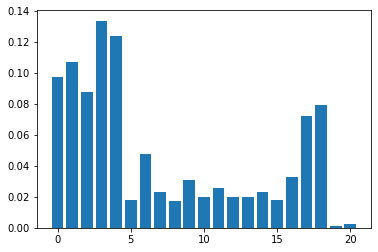

In [36]:
# Save the feature importances from the Random Forests classifier model to a variable named feature_importances
features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

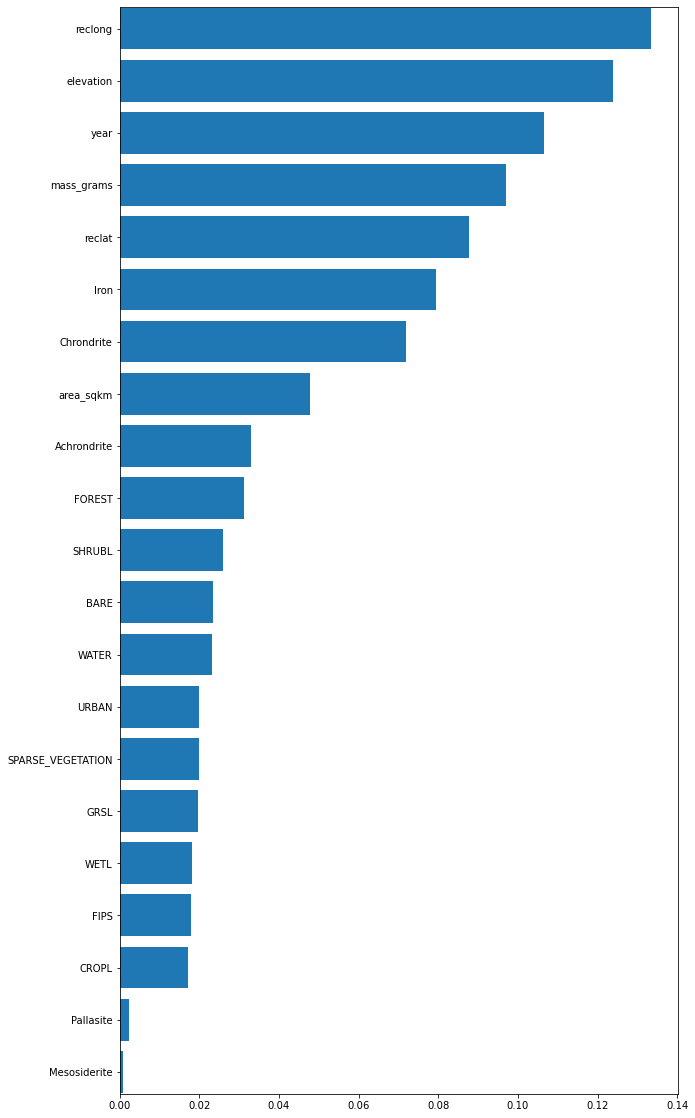

In [37]:
# Use the following code to plot the most important features
features = sorted(zip(X.columns, features), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,20)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()